**Part 1: Dataset Preparation and Fine-Tuning**

Step 1: Download the IMDB Dataset 

Dataset Shape: (50000, 2)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

First few rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values in each column:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


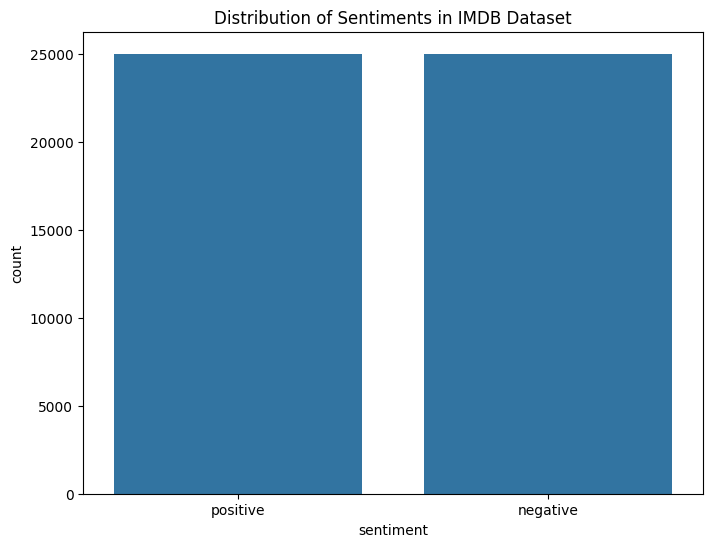


Dataset loaded successfully!

Sample positive review:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

Sample negative review:
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, J...


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

def load_imdb_dataset(filepath='C:/Users/Kone/Downloads/archive/IMDB Dataset.csv'):
    """Load the IMDB dataset and perform initial verification"""
    df = pd.read_csv(filepath)
    
    # Display basic information about the dataset
    print("Dataset Shape:", df.shape)
    print("\nDataset Info:")
    print(df.info())
    print("\nFirst few rows of the dataset:")
    print(df.head())
    print("\nMissing values in each column:")
    print(df.isnull().sum())
    print("\nSentiment distribution:")
    print(df['sentiment'].value_counts())
    
    # Create a distribution plot
    plt.figure(figsize=(8, 6))
    sns.countplot(x='sentiment', data=df)
    plt.title('Distribution of Sentiments in IMDB Dataset')
    plt.show()
    
    return df

# Load the dataset
df = load_imdb_dataset()
print("\nDataset loaded successfully!")

# Display sample reviews
print("\nSample positive review:")
print(df[df['sentiment'] == 'positive']['review'].iloc[0][:200] + "...")
print("\nSample negative review:")
print(df[df['sentiment'] == 'negative']['review'].iloc[0][:200] + "...")

Step 2: Data Preprocessing

In [3]:
def preprocess_data(df):
    """Preprocess the IMDB dataset"""
    # Encode sentiment labels (positive -> 1, negative -> 0)
    df['label'] = (df['sentiment'] == 'positive').astype(int)
    df = df[['review', 'label']]
    
    # Basic text cleaning
    df['review'] = df['review'].apply(lambda x: x.strip().lower())
    df = df[df['review'].str.len() > 0].reset_index(drop=True)
    
    # Split into training (80%), validation (10%), and test (10%) sets
    train_df, temp_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['label']
    )
    
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
    )
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    print("\nDataset splits:")
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")
    
    return train_df, val_df, test_df

# Apply preprocessing
train_df, val_df, test_df = preprocess_data(df)
print("\nPreprocessing completed successfully!")


Dataset splits:
Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples

Preprocessing completed successfully!


C:\Users\Kone\AppData\Local\Temp\ipykernel_37964\3489028217.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review'] = df['review'].apply(lambda x: x.strip().lower())


Step 3: Model Selection and Tokenization

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import torch
from tqdm.auto import tqdm

# Constants
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256
BATCH_SIZE = 32

class IMDBDataset(Dataset):
    """Custom Dataset for IMDB reviews"""
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            truncation=True,            # As per requirements
            padding='max_length',       # As per requirements
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize model and tokenizer
print(f"Loading model and tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    return_dict=True
)
print("Model and tokenizer loaded successfully!")

# Create datasets
train_dataset = IMDBDataset(train_df['review'].values, train_df['label'].values, tokenizer, MAX_LENGTH)
val_dataset = IMDBDataset(val_df['review'].values, val_df['label'].values, tokenizer, MAX_LENGTH)
test_dataset = IMDBDataset(test_df['review'].values, test_df['label'].values, tokenizer, MAX_LENGTH)

print(f"\nDatasets created successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Loading model and tokenizer: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer loaded successfully!

Datasets created successfully!
Training samples: 40000
Validation samples: 5000
Test samples: 5000


Step 4: Fine-Tune the Model 

In [5]:
from transformers import TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,                      # As per requirements
    per_device_train_batch_size=32,          # As per requirements (16 or 32)
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy="epoch",             # Evaluate at end of each epoch
    save_strategy="epoch",
    learning_rate=5e-5,                      # As per requirements
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"                         # Disable wandb reporting
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

# Train the model
print("Starting model training...")
trainer.train()

# Evaluate and print final metrics
final_metrics = trainer.evaluate()
print("\nFinal Evaluation Metrics:")
print(f"Accuracy: {final_metrics['eval_accuracy']:.4f}")
print(f"Precision: {final_metrics['eval_precision']:.4f}")
print(f"Recall: {final_metrics['eval_recall']:.4f}")
print(f"F1 Score: {final_metrics['eval_f1']:.4f}")

# Save final model and metrics
trainer.save_model("./results")
metrics_path = os.path.join("./results", "training_metrics.txt")
with open(metrics_path, "w") as f:
    for key, value in final_metrics.items():
        f.write(f"{key}: {value}\n")
print(f"\nModel and metrics saved to ./results")

c:\Users\Kone\ftllm\yes\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Kone\AppData\Local\Temp\ipykernel_37964\1383693292.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2025-02-04 18:59:28,916] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


W0204 18:59:29.656000 37964 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.235100,0.226612,0.908800,0.883346,0.942000,0.911731
2,0.136100,0.216756,0.924000,0.918311,0.930800,0.924513



Final Evaluation Metrics:
Accuracy: 0.9240
Precision: 0.9183
Recall: 0.9308
F1 Score: 0.9245

Model and metrics saved to ./results


Step 5: Save and Upload the Model to Hugging Face

In [14]:
from huggingface_hub import notebook_login
import os

# 1. Save model and tokenizer locally
output_dir = "./final_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model and tokenizer locally...")
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

# 2. Login to Hugging Face
print("\nPlease login to Hugging Face (a browser window will open)...")
notebook_login()

# 3. Push model to hub
repo_name = "Etwo02/imdb-sentiment-classifier"  # You can change this name
try:
    print(f"\nUploading model to Hugging Face Hub...")
    model.push_to_hub(repo_name)
    tokenizer.push_to_hub(repo_name)
    print(f"Model successfully uploaded to Hugging Face Hub!")
    print(f"You can find the model at: https://huggingface.co/{repo_name}")
    
except Exception as e:
    print(f"Error uploading model: {str(e)}")
    print("Please make sure you're logged in and have the correct permissions")

Saving model and tokenizer locally...
Model and tokenizer saved to ./final_model

Please login to Hugging Face (a browser window will open)...



Uploading model to Hugging Face Hub...


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Model successfully uploaded to Hugging Face Hub!
You can find the model at: https://huggingface.co/Etwo02/imdb-sentiment-classifier


4. Link to model https://huggingface.co/Etwo02/imdb-sentiment-classifier

**Part 2: API Development and Testing**

Step 6: Set Up the Backend API 

In [17]:
# main.py
# main.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F
from typing import Literal
import os
from dotenv import load_dotenv
import httpx
import json
import nest_asyncio
import uvicorn

# Apply nest_asyncio to allow running async code in Jupyter
nest_asyncio.apply()

# Load environment variables
load_dotenv()

app = FastAPI(
    title="Sentiment Analysis API",
    description="API for analyzing sentiment using custom DistilBERT and Llama 3 models",
    version="1.0.0"
)

# Model paths and configs
MODEL_PATH = "./final_model"  # Update with your model path
TOKENIZER_PATH = "./tokenizer_config"  # Update with your tokenizer path
MAX_LENGTH = 256

# Initialize custom model and tokenizer
custom_tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
custom_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
custom_model.eval()

# Groq API configuration
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GROQ_API_URL = "https://api.groq.com/v1/completions"

class SentimentRequest(BaseModel):
    text: str
    model: Literal["custom", "llama"]

class SentimentResponse(BaseModel):
    sentiment: str
    confidence: float

def analyze_with_custom_model(text: str) -> tuple[str, float]:
    """
    Analyze sentiment using the custom fine-tuned model
    """
    try:
        # Tokenize input
        inputs = custom_tokenizer(
            text,
            truncation=True,
            max_length=MAX_LENGTH,
            padding=True,
            return_tensors="pt"
        )

        # Get model prediction
        with torch.no_grad():
            outputs = custom_model(**inputs)
            probabilities = F.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            confidence = torch.max(probabilities).item()

        # Convert prediction to sentiment
        sentiment = "positive" if prediction.item() == 1 else "negative"
        
        return sentiment, confidence

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Custom model error: {str(e)}")

async def analyze_with_llama(text: str) -> tuple[str, float]:
    """
    Analyze sentiment using Llama 3 via Groq API
    """
    try:
        headers = {
            "Authorization": f"Bearer {GROQ_API_KEY}",
            "Content-Type": "application/json"
        }
        
        prompt = f"""Analyze the sentiment of the following text and respond with a JSON object containing two fields:
        1. "sentiment": either "positive" or "negative"
        2. "confidence": a float between 0 and 1 indicating your confidence

        Text: "{text}"

        Respond only with the JSON object."""

        payload = {
            "model": "llama2-70b-4096",  # or your chosen Llama 3 model
            "messages": [
                {"role": "system", "content": "You are a sentiment analysis expert."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 100
        }

        async with httpx.AsyncClient() as client:
            response = await client.post(GROQ_API_URL, headers=headers, json=payload)
            response.raise_for_status()
            
            # Parse the response
            result = response.json()
            content = result['choices'][0]['message']['content']
            parsed_result = json.loads(content)
            
            return parsed_result["sentiment"], float(parsed_result["confidence"])

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Llama model error: {str(e)}")

@app.post("/analyze/", response_model=SentimentResponse)
async def analyze_sentiment(request: SentimentRequest):
    """
    Analyze the sentiment of input text using either custom or Llama model
    """
    try:
        if request.model == "custom":
            sentiment, confidence = analyze_with_custom_model(request.text)
        else:  # llama
            sentiment, confidence = await analyze_with_llama(request.text)

        return SentimentResponse(
            sentiment=sentiment,
            confidence=confidence
        )

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

def run_server():
    """Function to run the server"""
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    server.run()

# For Jupyter Notebook
def start_server():
    """Function to start the server in a notebook"""
    import asyncio
    config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
    server = uvicorn.Server(config)
    asyncio.create_task(server.serve())
    return "Server started"

if __name__ == "__main__":
    run_server()

INFO:     Started server process [37964]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:64198 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:64218 - "POST /predict/?text=sad HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:64218 - "POST /predict/?text=sad HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:64242 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:64242 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:64243 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:64243 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:64244 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:64244 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:64279 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:64279 - "POST /analyze/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:64280 - "POST /analyze/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [37964]


KeyboardInterrupt: 

Step 7: Load Models

In [ ]:
# model_loader.py
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from huggingface_hub import login
import os
from dotenv import load_dotenv
import httpx
import json
from typing import Tuple, Optional
import asyncio

# Load environment variables
load_dotenv()

class ModelLoader:
    def __init__(self):
        # Environment variables
        self.hf_token = os.getenv("HUGGING_FACE_TOKEN")
        self.groq_api_key = os.getenv("GROQ_API_KEY")
        self.model_id = os.getenv("HF_MODEL_ID", "your-username/your-model-name")  # Update with your model ID
        
        # Model configurations
        self.custom_model = None
        self.custom_tokenizer = None
        self.max_length = 256
        
        # Groq API configuration
        self.groq_api_url = "https://api.groq.com/v1/chat/completions"
        self.groq_model = "mixtral-8x7b-32768"  # or your chosen Llama model
        
    def load_custom_model(self) -> Tuple[Optional[AutoModelForSequenceClassification], Optional[AutoTokenizer]]:
        """
        Load the fine-tuned model from Hugging Face
        """
        try:
            print("Loading custom model from Hugging Face...")
            
            # Login to Hugging Face
            if self.hf_token:
                login(self.hf_token)
            
            # Load tokenizer and model
            self.custom_tokenizer = AutoTokenizer.from_pretrained(self.model_id)
            self.custom_model = AutoModelForSequenceClassification.from_pretrained(
                self.model_id,
                num_labels=2  # Binary classification
            )
            
            # Set model to evaluation mode
            self.custom_model.eval()
            
            print("Custom model loaded successfully!")
            return self.custom_model, self.custom_tokenizer
            
        except Exception as e:
            print(f"Error loading custom model: {str(e)}")
            return None, None
    
    async def test_groq_connection(self) -> bool:
        """
        Test connection to Groq API
        """
        if not self.groq_api_key:
            print("Groq API key not found in environment variables")
            return False
            
        try:
            headers = {
                "Authorization": f"Bearer {self.groq_api_key}",
                "Content-Type": "application/json"
            }
            
            # Simple test prompt
            payload = {
                "model": self.groq_model,
                "messages": [
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": "Hello, are you there?"}
                ],
                "temperature": 0.1,
                "max_tokens": 50
            }
            
            async with httpx.AsyncClient() as client:
                response = await client.post(
                    self.groq_api_url,
                    headers=headers,
                    json=payload,
                    timeout=10.0
                )
                response.raise_for_status()
                
            print("Groq API connection successful!")
            return True
            
        except Exception as e:
            print(f"Error testing Groq API connection: {str(e)}")
            return False
    
    def get_groq_prompt(self, text: str) -> dict:
        """
        Generate the prompt for Groq API
        """
        return {
            "model": self.groq_model,
            "messages": [
                {
                    "role": "system",
                    "content": "You are a sentiment analysis expert. Analyze the sentiment of the given text and respond with a JSON object containing 'sentiment' (either 'positive' or 'negative') and 'confidence' (a float between 0 and 1)."
                },
                {
                    "role": "user",
                    "content": f"Analyze the sentiment of this text: '{text}'"
                }
            ],
            "temperature": 0.1,
            "max_tokens": 100
        }

# Usage example
async def initialize_models():
    """
    Initialize and test both models
    """
    # Create model loader instance
    loader = ModelLoader()
    
    # Load custom model
    custom_model, custom_tokenizer = loader.load_custom_model()
    if custom_model is None or custom_tokenizer is None:
        print("Failed to load custom model")
    
    # Test Groq API connection
    groq_connection = await loader.test_groq_connection()
    if not groq_connection:
        print("Failed to connect to Groq API")
    
    return loader, custom_model, custom_tokenizer

if __name__ == "__main__":
    # Create .env file template if it doesn't exist
    if not os.path.exists(".env"):
        with open(".env", "w") as f:
            f.write("""# Hugging Face token
HUGGING_FACE_TOKEN=your_token_here
# Groq API key
GROQ_API_KEY=your_groq_api_key_here
# Your fine-tuned model ID on Hugging Face
HF_MODEL_ID=your-username/your-model-name
""")
        print("Created .env template file. Please fill in your credentials.")
    
    # Run initialization
    asyncio.run(initialize_models())